In [1]:
!pip install nbformat


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import string
import re
import json
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
import plotly.graph_objects as go

## Charger les données de sentiment financier

In [3]:
# Charger les données de sentiment financier
finance_data = pd.read_csv('data.csv')
finance_data.columns = finance_data.columns.str.strip()  # Supprimer les espaces autour des noms de colonnes
print(finance_data.columns)

Index(['Sentence', 'Sentiment'], dtype='object')


## Charger les Stop Word (il sont en français pour le moment)

In [4]:
# Charger les Stop Words en anglais
with open('stopwords-en.json', encoding="utf-8") as json_file:
    stop_words = set(json.load(json_file))

## Fonction de Nettoyage de Texte

In [5]:
# Fonction de nettoyage de texte
tokenizer = TweetTokenizer()

def process_finance_text(text):
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)  # Supprimer les URLs
    text = re.sub(r'#', '', text)  # Supprimer les hashtags
    tokens = tokenizer.tokenize(text.lower())  # Tokenisation en minuscules
    clean_tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return clean_tokens



In [6]:
# Appliquer la fonction de nettoyage sur les données financières
finance_data['processed_text'] = finance_data['Sentence'].apply(process_finance_text)

In [7]:
finance_data.head()

Sentence Sentiment  \
0  The GeoSolutions technology will leverage Bene...  positive   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative   
2  For the last quarter of 2010 , Componenta 's n...  positive   
3  According to the Finnish-Russian Chamber of Co...   neutral   
4  The Swedish buyout firm has sold its remaining...   neutral   

                                      processed_text  
0  [geosolutions, technology, leverage, benefon, ...  
1     [esi, lows, 1.50, 2.50, bk, real, possibility]  
2  [quarter, 2010, componenta, sales, doubled, eu...  
3  [finnish-russian, chamber, commerce, major, co...  
4  [swedish, buyout, firm, sold, remaining, 22.4,...

In [8]:
finance_data.iloc[4,][0]

/var/folders/m8/td3v54hx7jv79vgwyg6xbxbc0000gn/T/ipykernel_18153/1453724271.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  finance_data.iloc[4,][0]


'The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .                                                                                                                                                                                     '

In [9]:
print(finance_data.Sentiment.value_counts())

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64


## Charger un Modèle Word2Vec Pré-entraîné (Spécifique à la Finance)

In [ ]:

# Charger le modèle Google News Word2Vec
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

# Exemple de mots similaires
print(model.most_similar('bank'))
print(model.most_similar('investment'))
list(model.key_to_index)[:10]

In [ ]:
# Fonction de similarité cosinus
def cosine_similarity(word1, word2):
    if word1 in model and word2 in model:
        vec1 = model[word1]
        vec2 = model[word2]
        cos_sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        return cos_sim
    else:
        return None

# Exemple de calcul de similarité
print("Similarité entre 'bank' et 'finance':", cosine_similarity('bank', 'finance'))

Similarité entre 'bank' et 'finance': 0.33500585


In [ ]:
# Fonction d'analogie
def analogy(word_a, word_b, word_c):
    if all(word in model for word in [word_a, word_b, word_c]):
        result = model.most_similar(positive=[word_b, word_c], negative=[word_a])
        return result[0][0]
    return None

# Exemple d'analogie
print("Analogie : bank - money + investment =", analogy('bank', 'money', 'investment'))

Analogie : bank - money + investment = investments


In [ ]:
from nltk import FreqDist

def Bag_Of_Words(processed_texts):
    all_words = []
    for text in processed_texts:
        for word in text:  # text est déjà une liste de mots car processed_text contient des tokens
            all_words.append(word.lower())
    word_freq = FreqDist(all_words)
    return word_freq


sac_de_mots = Bag_Of_Words(finance_data['processed_text'])

# Pour voir les mots les plus communs
print("Les 20 mots les plus fréquents:")
print(sac_de_mots.most_common(20))

Les 20 mots les plus fréquents:
[('eur', 1731), ('company', 810), ('profit', 568), ('sales', 560), ('finnish', 527), ('operating', 371), ('2009', 354), ('mln', 351), ('2008', 342), ('period', 331), ('finland', 319), ('quarter', 312), ('2007', 299), ('share', 288), ('2010', 255), ('oyj', 250), ('business', 245), ('shares', 229), ('market', 229), ('loss', 221)]


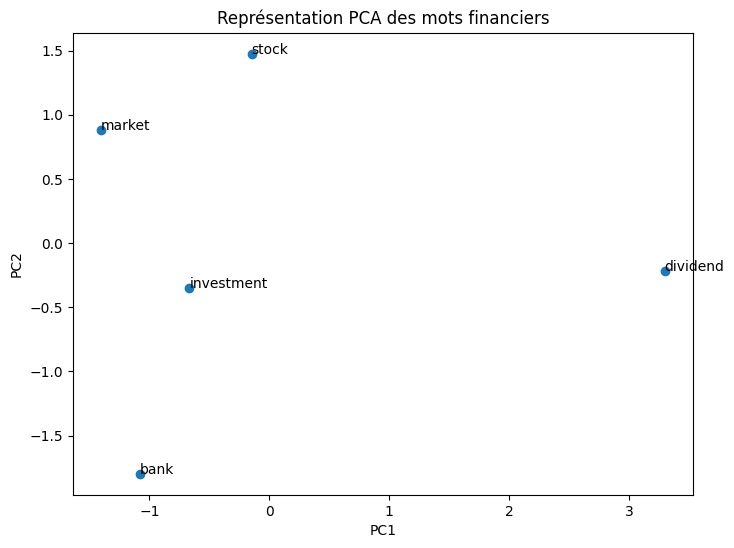

In [ ]:
# 1. Visualisation de mots financiers en 2D avec PCA
def plot_finance_words(words):
    word_vectors = np.array([model[word] for word in words if word in model])
    labels = [word for word in words if word in model]
    pca = PCA(n_components=2)
    result = pca.fit_transform(word_vectors)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(result[:, 0], result[:, 1])
    
    for i, word in enumerate(labels):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.title("Représentation PCA des mots financiers")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

# Exemple de visualisation
finance_words = ['bank', 'market', 'investment', 'stock', 'dividend']
plot_finance_words(finance_words)


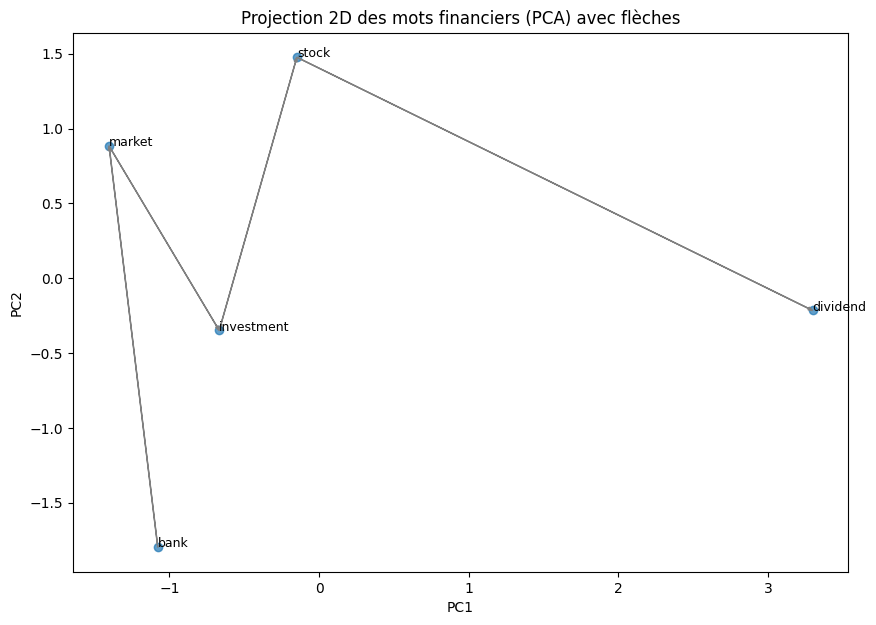

In [ ]:
# 2. Visualisation 2D avec des flèches (pour montrer des relations entre mots)
def plot_data_2D(words):
    word_vectors = np.array([model[word] for word in words if word in model])
    labels = [word for word in words if word in model]
    
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(word_vectors)
    
    plt.figure(figsize=(10, 7), dpi=100)
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.7)
    
    for i, label in enumerate(labels):
        plt.annotate(label, (transformed_data[i, 0], transformed_data[i, 1]), fontsize=9)
    
    for i in range(len(transformed_data) - 1):
        plt.arrow(transformed_data[i, 0], transformed_data[i, 1],
                  transformed_data[i + 1, 0] - transformed_data[i, 0],
                  transformed_data[i + 1, 1] - transformed_data[i, 1],
                  head_width=0.02, color='gray', length_includes_head=True)
    
    plt.title("Projection 2D des mots financiers (PCA) avec flèches")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plot_data_2D(finance_words)

Nombre total de mots : 61068


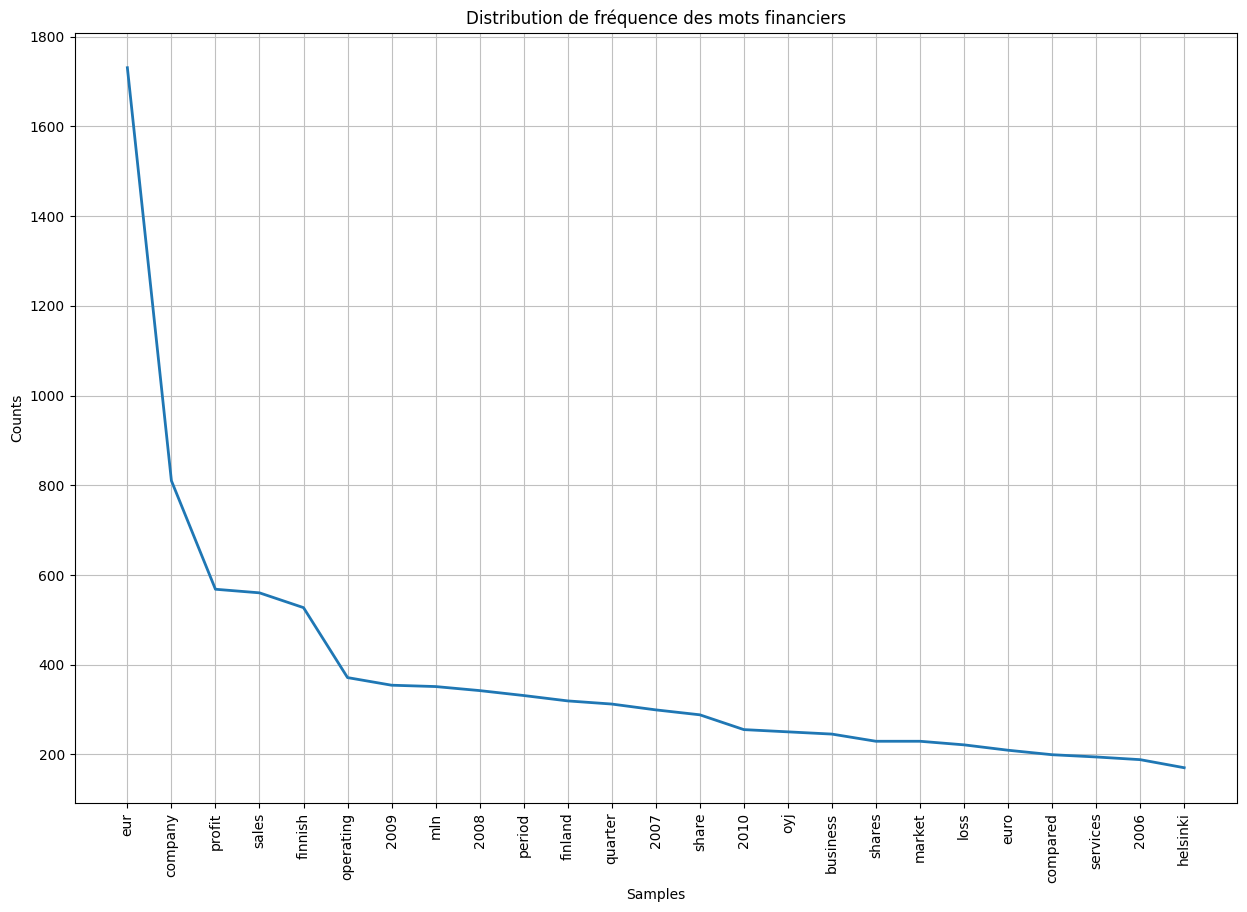

In [ ]:
# 3. Distribution de fréquence des mots
sac_de_mots = finance_data['processed_text'].explode()
print("Nombre total de mots :", len(sac_de_mots))

plt.figure(figsize=(15, 10))
freq_dist = FreqDist(sac_de_mots)
freq_dist.plot(25)
plt.title("Distribution de fréquence des mots financiers")
plt.show()

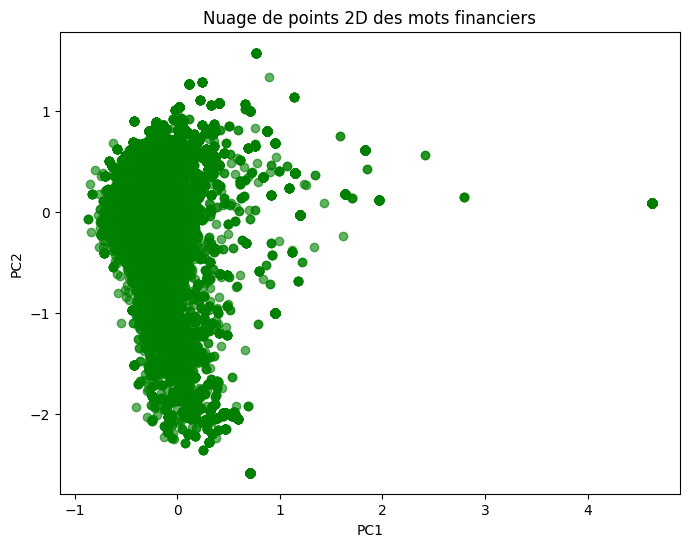

In [ ]:
# 4. Visualisation en 2D simple
def plot_2D_simple(words):
    word_vectors = np.array([model[word] for word in words if word in model])
    pca = PCA(n_components=2)
    result = pca.fit_transform(word_vectors)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(result[:, 0], result[:, 1], color='green', alpha=0.6)
    plt.title("Nuage de points 2D des mots financiers")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plot_2D_simple(sac_de_mots)

In [ ]:

# 5. Visualisation en 3D avec Plotly
def plot_data_3D(words):
    word_vectors = np.array([model[word] for word in words if word in model])
    labels = [word for word in words if word in model]
    
    pca = PCA(n_components=3)
    result = pca.fit_transform(word_vectors)
    
    fig = go.Figure(data=[go.Scatter3d(
        x=result[:, 0], 
        y=result[:, 1], 
        z=result[:, 2],
        mode='markers+text',
        marker=dict(size=5),
        text=labels
    )])
    
    fig.update_layout(
        title="Projection 3D des mots financiers",
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3"
        )
    )
    fig.show()

# Affichage en 3D
plot_data_3D(sac_de_mots)